# Pipeline for generating snow depth maps from a source DEM and a reference DEM

In [1]:
import os, glob
import geedim as gd
import ee
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import numpy as np
from tqdm.auto import tqdm
import xdem
import geoutils as gu
import pyproj
from scipy.stats import median_abs_deviation as MAD
import math
import pandas as pd

/opt/anaconda3/envs/snow-dems/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define paths to DEMs

In [2]:
# Define site name and source DEM date for convenience
site_name = 'MCS'
sourcedem_date = '20240420'
# data_path = f'/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/study-sites/{site_name}'
data_path = f'/Users/rdcrlrka/Research/PhD/SkySat-Stereo/study-sites/{site_name}/'
refdem_fn = os.path.join(data_path, 'refdem', 'MCS_REFDEM_WGS84.tif')
sourcedem_fn = glob.glob(os.path.join(data_path, sourcedem_date, '*DEM_masked.tif'))[0]

# Define path for output snow depth images
# out_dir = '/Volumes/LaCie/raineyaberle/Research/PhD/SkySat-Stereo/snow_depth_maps'
out_dir = f'/Users/rdcrlrka/Research/PhD/SkySat-Stereo/snow_depth_maps/'

# Check that files exist
# if not os.path.exists(refdem_fn):
#     print('Reference DEM not found, check path to file before continuing.')
if not os.path.exists(sourcedem_fn):
    print('Source DEM not found, check path to file before continuing.')
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    print('Created directory for output files:', out_dir)

## Construct stable surface mask for source DEM

In [3]:
def convert_wgs_to_utm(lon: float, lat: float):
    """
    Return best UTM EPSG code based on WGS84 lat and lon coordinate pair. 

    Parameters
    ----------
    lon: float
        longitude coordinate
    lat: float
        latitude coordinate

    Returns
    ----------
    epsg_code: str
        optimal UTM zone, e.g. "EPSG:32606"
    """
    utm_band = str((math.floor((lon + 180) / 6) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0' + utm_band
    if lat >= 0:
        epsg_code = 'EPSG:326' + utm_band
        return epsg_code
    epsg_code = 'EPSG:327' + utm_band
    
    return epsg_code

def query_gee_for_image(dem_fn, dem_date, site_name, out_dir):
    """
    Query Google Earth Engine for Landsat 8 and 9 surface reflectance (SR), Sentinel-2 top of atmosphere (TOA) or SR imagery.
    Images captured within the hour will be mosaicked. For each image, run the classification and snowline detection workflow.

    Parameters
    __________
    dem_bounds: list, numpy.array
        bounds of the DEM used for querying and clipping imagery (format = [xmin, ymin, xmax, ymax])
    date_date: str
        date of the DEM (format = 'YYYYMMDD')
    out_dir: str
        path in directory where image will be saved

    Returns
    __________
    im_xr: xarray.Dataset
        resulting image
    """

    # -----Authenticate and initialize GEE
    try:
        ee.Initialize()
    except:
        ee.Authenticate()
        ee.Initialize()
    
    # -----Load DEM
    dem = xr.open_dataset(dem_fn)
    # Grab lat lon image bounds
    dem_bounds = dem.rio.reproject('EPSG:4326').rio.bounds()
    
    # -----Estimate best UTM zone
    centroid_lon = (dem_bounds[0] + dem_bounds[2]) / 2
    centroid_lat = (dem_bounds[1] + dem_bounds[3]) / 2
    crs = convert_wgs_to_utm(centroid_lon, centroid_lat)
    print(f'Best UTM zone = {crs}')
    
    # -----Reformat image bounds for image querying and clipping
    region = {'type': 'Polygon',
              'coordinates': [[[dem_bounds[0], dem_bounds[1]],
                              [dem_bounds[2], dem_bounds[1]],
                              [dem_bounds[2], dem_bounds[3]],
                              [dem_bounds[0], dem_bounds[3]],
                              [dem_bounds[0], dem_bounds[1]]
                             ]]
             }

    # -----Define the start and end dates for query (within two weeks of DEM date)
    if '-' in dem_date:
        dem_date = dem_date.replace('-','')
    dem_dt = np.datetime64(f'{dem_date[0:4]}-{dem_date[4:6]}-{dem_date[6:8]}')
    start_date = str(dem_dt - np.timedelta64(2, 'W'))
    end_date = str(dem_dt + np.timedelta64(2, 'W'))

    # -----Query GEE for imagery
    im_col = gd.MaskedCollection.from_name('COPERNICUS/S2_SR_HARMONIZED').search(start_date=start_date,
                                                                                 end_date=end_date,
                                                                                 region=region,
                                                                                 mask=True,
                                                                                 fill_portion=70)
    im_col_ids = np.array(im_col.ee_collection.aggregate_array('system:id').getInfo())
    def sts_to_date(sts):
        return ee.Date(sts).format('yyyy-MM-dd')
    im_col_dts = np.array(im_col.ee_collection.aggregate_array('system:time_start').map(sts_to_date).getInfo(), dtype='datetime64[D]')

    # -----Download the closest image in time
    # Identify ID of the closest image in time
    dt_diffs = dem_dt - im_col_dts
    Iclosest = np.ravel(np.argwhere(dt_diffs==np.min(dt_diffs)))[0]
    im_id = im_col_ids[Iclosest] 
    im_dt = im_col_dts[Iclosest] 
    print(f'Closest image date = {im_dt}')
    # Create new masked image from ID
    im = gd.MaskedImage.from_id(im_id, mask=True, region=region)
    # Download to file
    out_fn = os.path.join(os.path.dirname(out_dir), f"{site_name}_{str(im_dt).replace('-','')}_S2_SR_HARMONIZED.tif")
    refl_bands = im.refl_bands
    if not os.path.exists(out_fn):
        im.download(out_fn, region=region, scale=10, crs=crs, bands=refl_bands, dtype='int16')
        print('Sentinel-2 image saved to file:', out_fn)
    else:
        print('Sentinel-2 image file already exists in directory, loading...')

    # -----Open image and restructure data variables
    im_xr = xr.open_dataset(out_fn)
    band_data = im_xr['band_data']
    im_xr_adj = xr.Dataset()
    for i, band_name in enumerate(refl_bands):
        im_xr_adj[band_name] = band_data.isel(band=i)
    im_xr_adj.attrs = im_xr.attrs
    for coord in im_xr.coords:
        im_xr_adj[coord] = im_xr[coord]
    im_xr_adj = im_xr_adj / 1e4 # account for reflectance scalar
    
    return im_xr_adj, crs

def create_stable_surface_mask(im_xr, dem_date, out_fn, crs, plot=True):
    """
    Create stable surface mask by applying an NDSI threshold of 0.35 to the input Sentinel-2 SR image

    Parameters
    ----------
    im_xr: xarray.Dataset
        input Sentinel-2 SR image
    dem_date: str
        observation date of DEM
    out_fn: str
        file name of output stable surfaces file
    crs: str
        coordinate reference system of output file (e.g., "EPSG:4326")
    plot: bool
        whether to plot results
    
    Returns
    ----------
    stable_surfaces: xarray.DataArray
        resulting stable surfaces mask
    
    """
    # Add NDSI band
    im_xr['NDSI'] = (im_xr['B3'] - im_xr['B11']) / (im_xr['B3'] + im_xr['B11'])
    
    # Threshold
    ss_xr = xr.where(im_xr['NDSI'] <= 0.4, 1, 0)

    # Calculate statistics
    num_pixels = len(np.ravel(ss_xr.data))
    num_pixels_stable = len(np.argwhere(np.ravel(ss_xr.data)==1))
    res_m2 = (ss_xr.x.data[1] - ss_xr.x.data[0]) **2
    perc_stable = num_pixels_stable / num_pixels * 100
    area_stable_km2 = num_pixels_stable * res_m2 / 1e6
    print(f'Stable surfaces = {np.round(perc_stable,2)} % of image, {np.round(area_stable_km2, 2)} km2')

    # Write CRS to image
    ss_xr = ss_xr.rio.write_crs(crs)
    
    # Save to file
    ss_xr.rio.to_raster(out_fn)
    print('Stable surfaces mask saved to file:', out_fn)

    ss_xr = rxr.open_rasterio(out_fn)
    
    # Plot
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(12,6))
        ax[0].imshow(np.dstack([im_xr.B4.data, im_xr.B3.data, im_xr.B2.data]),
                     extent=(np.min(im_xr.x.data), np.max(im_xr.x.data), np.min(im_xr.y.data), np.max(im_xr.y.data)))
        ax[0].set_title('Raw image')
        ax[1].imshow(im_xr.NDSI.data, clim=(-1,1), cmap='Blues',
                     extent=(np.min(im_xr.x.data), np.max(im_xr.x.data), np.min(im_xr.y.data), np.max(im_xr.y.data)))
        ax[1].set_title('NDSI')
        ax[2].imshow(ss_xr.data[0], clim=(0,1), cmap='Greys',
                     extent=(np.min(ss_xr.x.data), np.max(ss_xr.x.data), np.min(ss_xr.y.data), np.max(ss_xr.y.data)))
        ax[2].set_title('Stable surfaces')
        plt.show()
        # save figure
        fig_fn = os.path.splitext(out_fn)[0] + '.png'
        fig.savefig(fig_fn, dpi=250, bbox_inches='tight')
        print('Figure saved to file:', fig_fn)

    return ss_xr
    

In [4]:
# Check if stable surfaces mask already exists in file
ss_fn = os.path.join(out_dir, os.path.splitext(os.path.basename(sourcedem_fn))[0] + '_stable_surfaces_mask.tif')
if os.path.exists(ss_fn):
    print('Stable surfaces mask already exists for DEM')
    ss_xr = rxr.open_rasterio(ss_fn)

else:
    # Query GEE for closest Sentinel-2 image in time
    im_xr, crs = query_gee_for_image(sourcedem_fn, sourcedem_date, site_name, out_dir)
    
    # Create stable surfaces mask
    ss_xr = create_stable_surface_mask(im_xr, sourcedem_date, ss_fn, crs=crs, plot=True)

Stable surfaces mask already exists for DEM


## Define functions for coregistration

In [10]:
def create_coreg_object(coreg_name):
    if type(coreg_name) == list:
        try:
            coreg_class = getattr(xdem.coreg.CoregPipeline, coreg_name)
            return coreg_class()
        except AttributeError:
            raise ValueError(f"Coregistration method '{coreg_name}' not found.")
    elif type(coreg_name) == str:
        try:
            coreg_class = getattr(xdem.coreg, coreg_name)
            return coreg_class()
        except AttributeError:
            raise ValueError(f"Coregistration method '{coreg_name}' not found.")
    else:
        print('coreg_method format not recognized, exiting...')
        return None


def differences_vs_slope_aspect(dem, diffs):
    # Calculate slope and aspect from DEM
    slope = xdem.terrain.slope(dem)
    aspect = xdem.terrain.aspect(dem)
    
    # Compile differences, slopes, and aspects in a dataframe
    df = pd.DataFrame({'diff': np.ravel(diffs.data),
                       'elev': np.ravel(dem.data),
                       'slope': np.ravel(slope.data),
                       'aspect': np.ravel(aspect.data)})
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    # Create bins for elev, slope, and aspect
    df['elev_bin'] = pd.cut(df['elev'], bins=10)
    df['slope_bin'] = pd.cut(df['slope'], bins=np.arange(0, 41, step=5))
    df['aspect_bin'] = pd.cut(df['aspect'], bins=np.arange(0, 361, step=45))

    # Plot
    fig, ax = plt.subplots(3, 1, figsize=(8,16))
    # elev
    df.boxplot(column='diff', by='elev_bin', showfliers=False, ax=ax[0])
    ax[0].set_title('')
    ax[0].set_xlabel('Elevation range [m]')
    ax[0].set_ylabel('Differences [m]')
    # slope
    df.boxplot(column='diff', by='slope_bin', showfliers=False, ax=ax[1])
    ax[1].set_title('')
    ax[1].set_xlabel('Slope range [degrees]')
    ax[1].set_ylabel('Differences [m]')
    # aspect
    df.boxplot(column='diff', by='aspect_bin', showfliers=False, ax=ax[2])
    ax[2].set_title('')
    ax[2].set_xlabel('Aspect range [degrees from North]')
    ax[2].set_ylabel('Differences [m]')
    fig.tight_layout()
    
    return 


def coregister_difference(ref_dem_fn=None, source_dem_fn=None, ss_mask_fn=None, coreg_method='NuthKaab', coreg_ss_only=False):
    # Load DEMs and stable surface mask
    ref_dem = xdem.DEM(gu.Raster(ref_dem_fn, load_data=True, bands=1))
    tba_dem = xdem.DEM(gu.Raster(source_dem_fn, load_data=True, bands=1))
    ss_mask = gu.Raster(ss_fn, load_data=True)
    ss_mask = (ss_mask == 0)  # Convert to boolean mask
    
    # Reproject source DEM and stable surface mask to reference DEM grid
    tba_dem = tba_dem.reproject(ref_dem)
    ss_mask = ss_mask.reproject(ref_dem)
    
    # Set up the coregistration object
    coreg_obj = create_coreg_object(coreg_method)
    
    # Calculate differences before coregistration
    print('Calculating differences before coregistration...')
    diff_before = tba_dem - ref_dem
    # diff_before.set_nodata(-9999)
    # Stable surface stats
    diff_before_ss = np.ma.masked_where(np.logical_or(diff_before.data.mask, ss_mask.data), diff_before.data)
    diff_before_ss_median = np.ma.median(diff_before_ss)
    diff_before_ss_nmad = xdem.spatialstats.nmad(diff_before_ss)

    # Fit the coregistration object
    print('Coregistering source DEM to reference DEM...')
    if coreg_ss_only:
        coreg_obj.fit(ref_dem, tba_dem, ss_mask)   
    else:
        coreg_obj.fit(ref_dem, tba_dem)
    print(coreg_obj.meta)
    
    # Apply the coregistration object
    aligned_dem = coreg_obj.apply(tba_dem)
    
    # Calculate differences after coregistration
    print('Calculating differences after coregistration...')
    diff_after = aligned_dem - ref_dem
    # diff_after.set_nodata(-9999)
    # Stable surface stats
    diff_after_ss = np.ma.masked_where(np.logical_or(diff_after.data.mask, ss_mask.data), diff_after.data)
    diff_after_ss_median = np.ma.median(diff_after_ss)
    diff_after_ss_nmad = xdem.spatialstats.nmad(diff_after_ss)
    
    # Plotting
    print('Plotting results...')
    fig, ax = plt.subplots(2, 2, figsize=(12,12))
    ax = ax.flatten()
    # Differences before coregistration
    vmax_abs = np.nanmax([np.abs(diff_before.data.min()), np.abs(diff_before.data.min())])
    vmin, vmax = -vmax_abs, vmax_abs
    diff_before.plot(cmap="coolwarm_r", ax=ax[0], vmin=vmin, vmax=vmax)
    ax[0].set_title(f'Difference before coreg. \nSS median = {np.round(diff_before_ss_median, 3)}, SS NMAD = {np.round(diff_before_ss_nmad, 3)}')
    ax[1].hist(np.ravel(diff_before.data), bins=50, color='grey', label='All surfaces')
    ax[1].hist(np.ravel(diff_before_ss.data), bins=50, color='grey', label='Stable surfaces')
    ax[1].set_xlabel('Differences [m]')
    ax[1].set_ylabel('Counts')
    # Differences after coregistration
    vmax_abs = np.nanmax([np.abs(diff_after.data.min()), np.abs(diff_after.data.min())])
    vmin, vmax = -vmax_abs, vmax_abs
    diff_after.plot(cmap="coolwarm_r", ax=ax[2], vmin=vmin, vmax=vmax)
    ax[2].set_title(f'Difference after coreg. \nSS median = {np.round(diff_after_ss_median, 3)}, SS NMAD = {np.round(diff_after_ss_nmad, 3)}')
    ax[3].hist(np.ravel(diff_after.data), bins=50, color='grey', label='All surfaces')
    ax[3].hist(np.ravel(diff_after_ss.data), bins=50, color='grey', label='Stable surfaces')
    ax[3].set_xlabel('Differences [m]')
    ax[3].set_ylabel('Counts')
    # Adjust map units to km
    for axis in [ax[0], ax[2]]:
        axis.set_xticks(axis.get_xticks())
        axis.set_xticklabels(np.divide(axis.get_xticks(), 1e3).astype(str))
        axis.set_yticks(axis.get_yticks())
        axis.set_yticklabels(np.divide(axis.get_yticks(), 1e3).astype(str))
        axis.set_xlabel('Easting [km]')
        axis.set_ylabel('Northing [km]')
    fig.tight_layout()
    
    plt.show()

    # Calculate differences as a function of slope and aspect
    print('Calculating differences as a function of slope and aspect...')
    differences_vs_slope_aspect(ref_dem, diff_after)

    return diff_after


### Nuth and Kaab - all surfaces

/opt/anaconda3/envs/snow-dems/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


Calculating differences before coregistration...
Coregistering source DEM to reference DEM...
{'subsample': 500000.0, 'random_state': None, 'subsample_final': 500000, 'shift_x': 3.517500000005097, 'shift_y': 8.193500000011873, 'shift_z': -19.649615224608965}
Calculating differences after coregistration...
Plotting results...


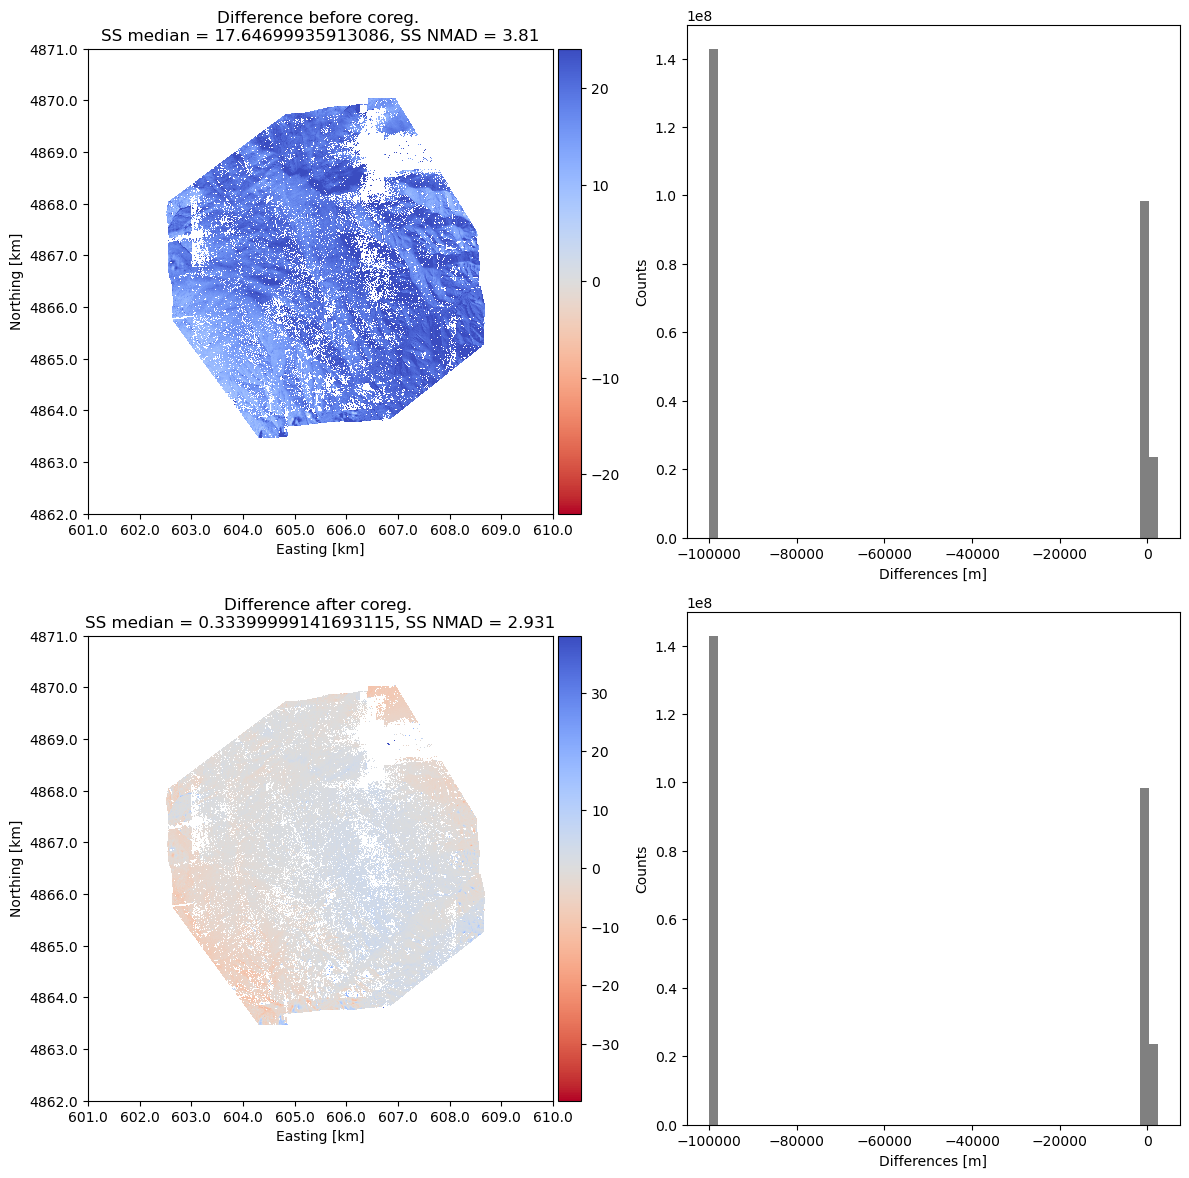

Calculating differences as a function of slope and aspect...


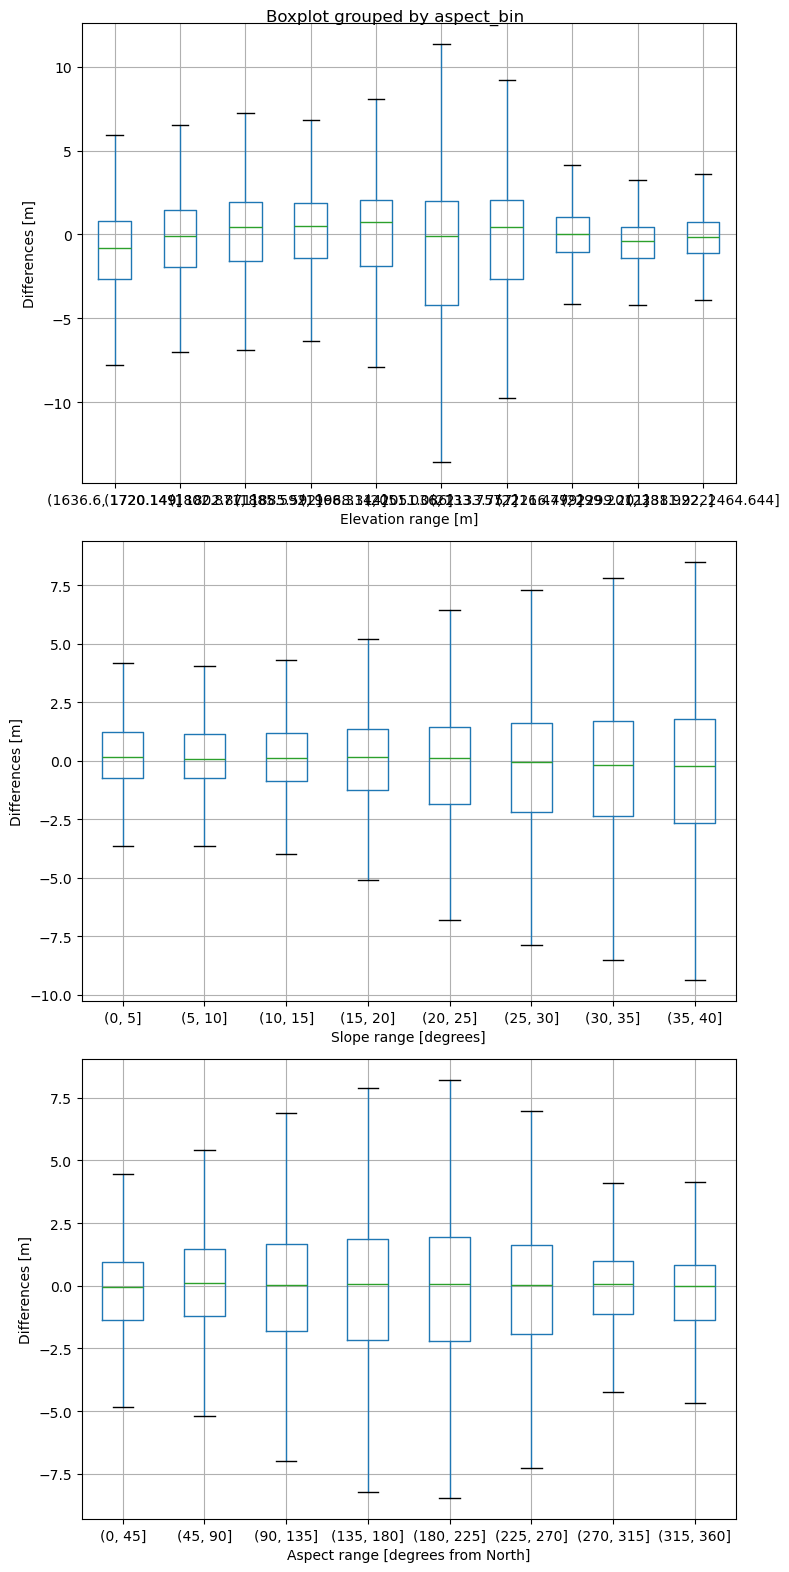

In [11]:
diff_after = coregister_difference(ref_dem_fn=refdem_fn, 
                                   source_dem_fn=sourcedem_fn, 
                                   ss_mask_fn=ss_fn, 
                                   coreg_method='NuthKaab', 
                                   coreg_ss_only=False)


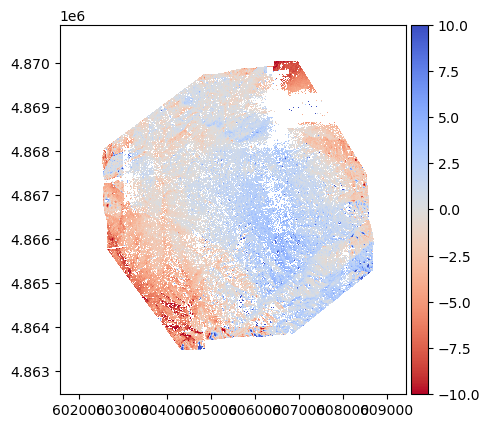

In [12]:
diff_after.plot(vmin=-10, vmax=10, cmap='coolwarm_r')
plt.show()

### Nuth and Kaab - stable surfaces only

/opt/anaconda3/envs/snow-dems/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


Calculating differences before coregistration...
Coregistering source DEM to reference DEM...
{'subsample': 500000.0, 'random_state': None, 'subsample_final': 500000, 'shift_x': 3.5730000000051776, 'shift_y': 8.75700000001269, 'shift_z': -19.558738164550505}
Calculating differences after coregistration...
Plotting results...


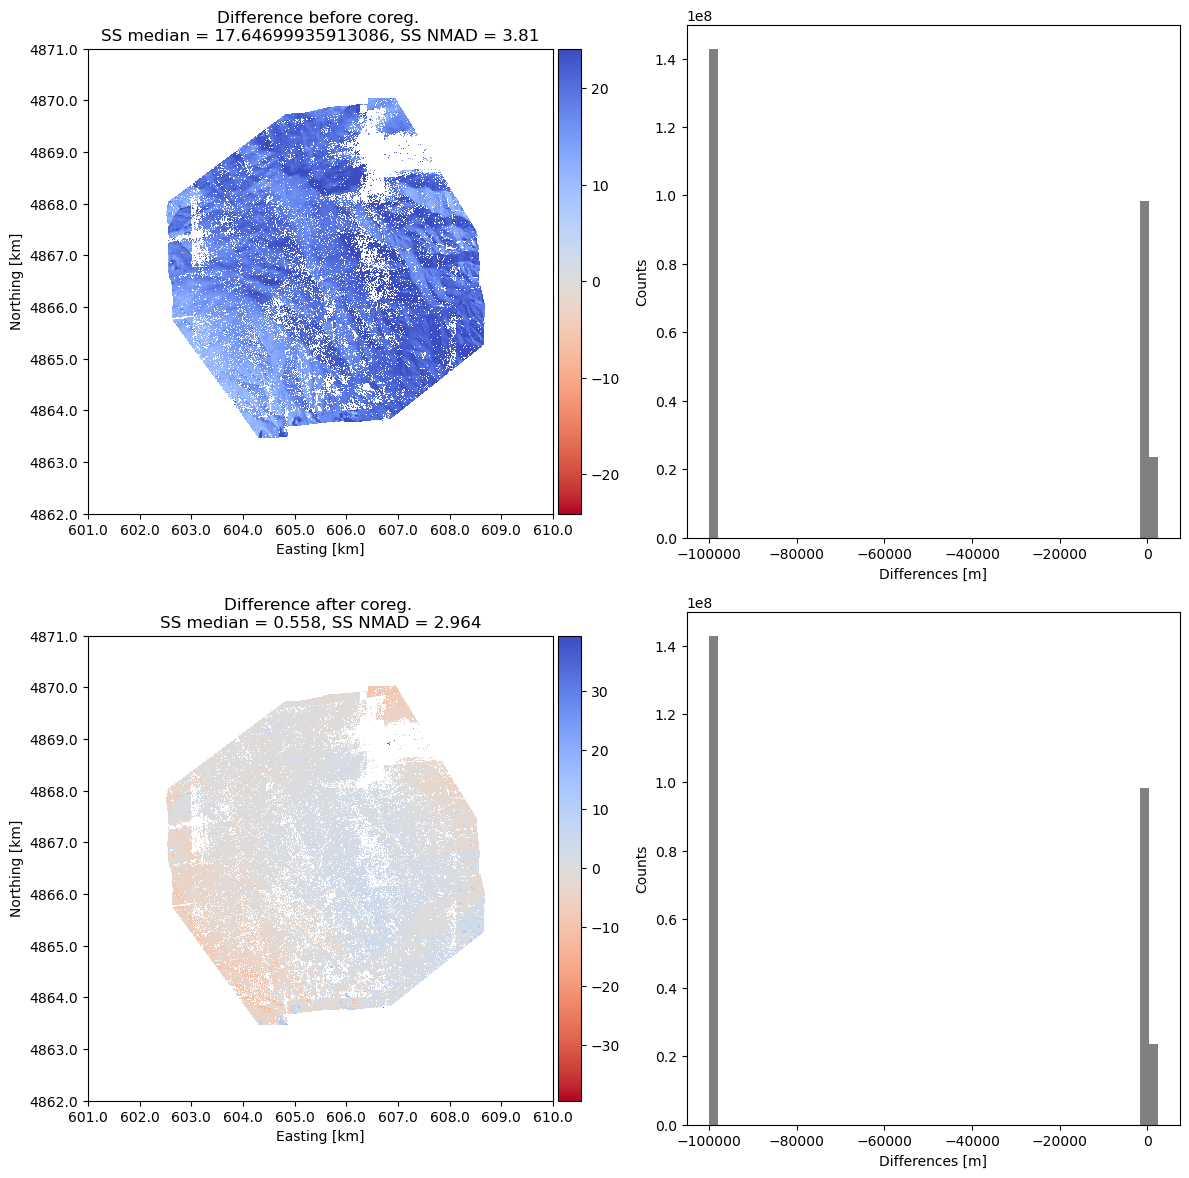

Calculating differences as a function of slope and aspect...


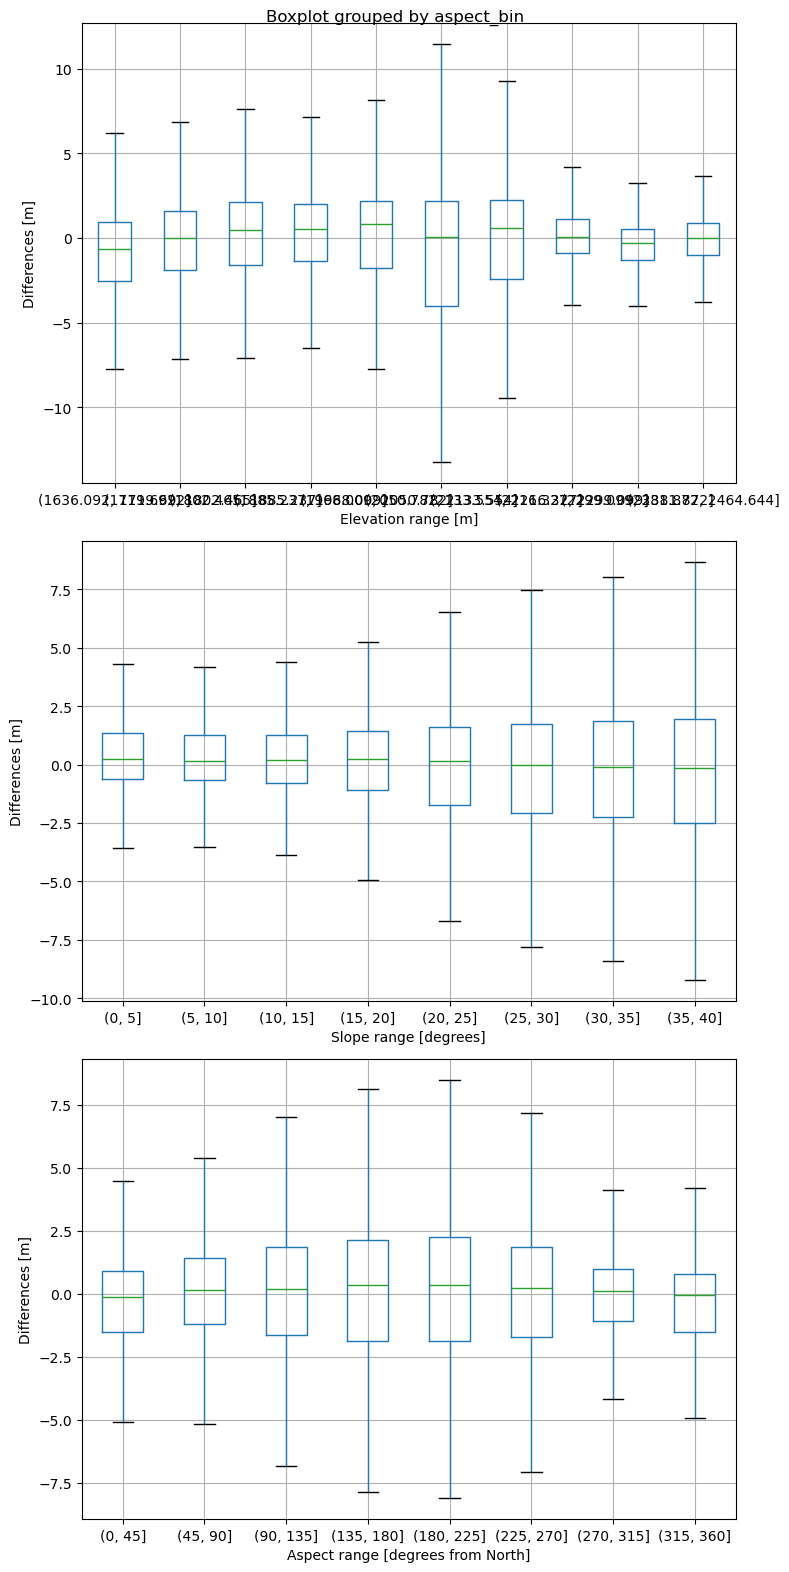

In [13]:
diff_after = coregister_difference(ref_dem_fn=refdem_fn, 
                                   source_dem_fn=sourcedem_fn, 
                                   ss_mask_fn=ss_fn, 
                                   coreg_method='NuthKaab', 
                                   coreg_ss_only=True)

### Gradient Descending - all surfaces

/opt/anaconda3/envs/snow-dems/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


Calculating differences before coregistration...
Coregistering source DEM to reference DEM...
{'subsample': 6000, 'random_state': None, 'shift_x': 1.4823750000000002, 'shift_y': 1.4980937499999998, 'shift_z': -19.69390869140625}
Calculating differences after coregistration...
Plotting results...


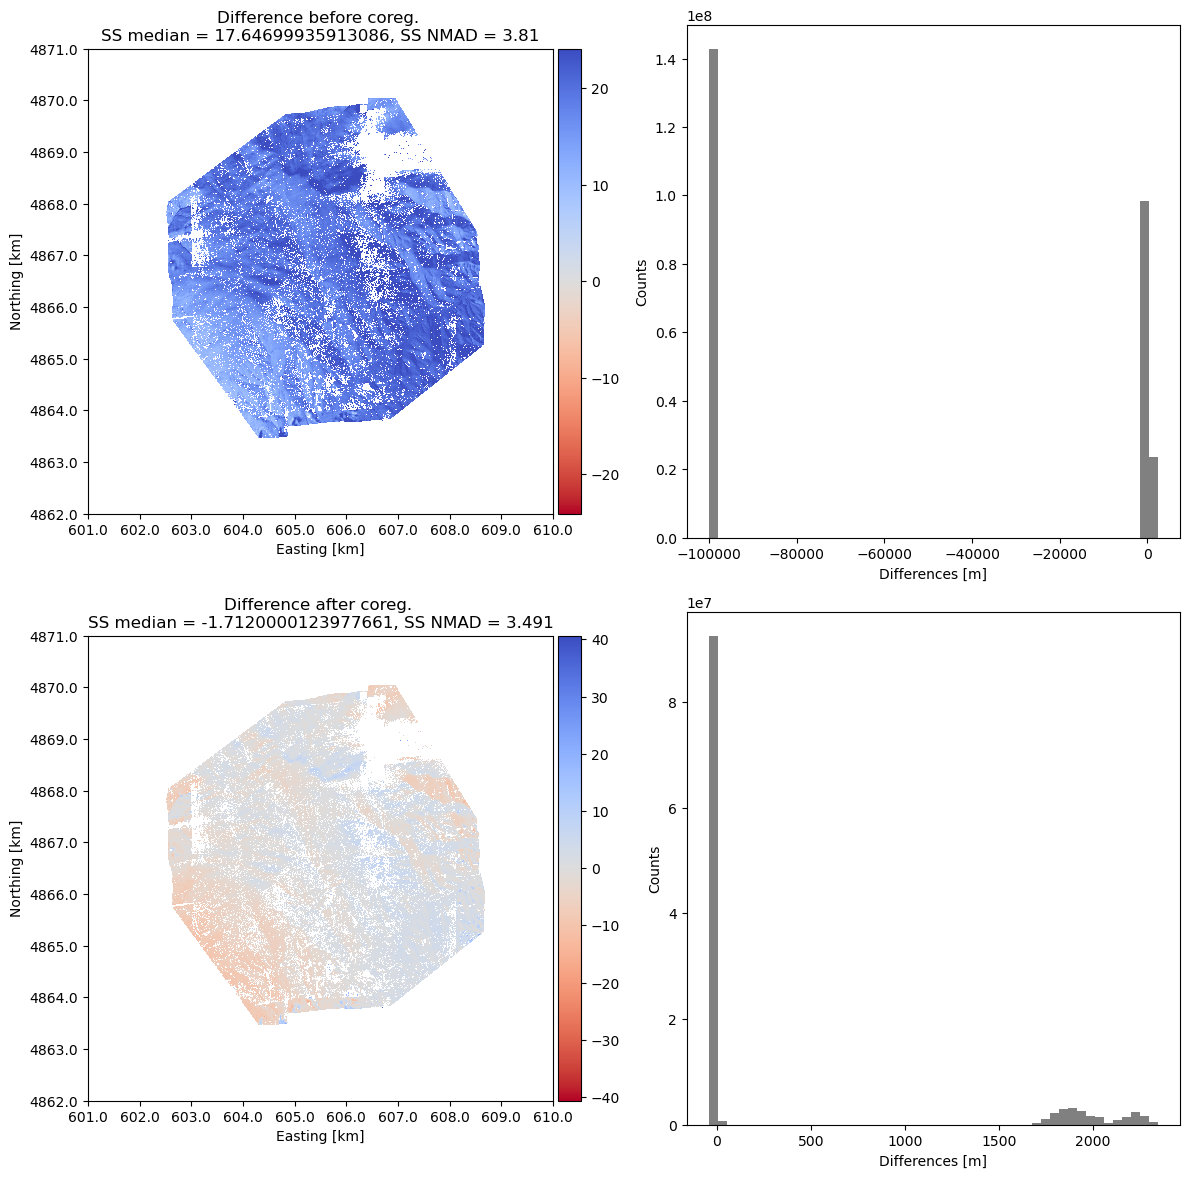

Calculating differences as a function of slope and aspect...


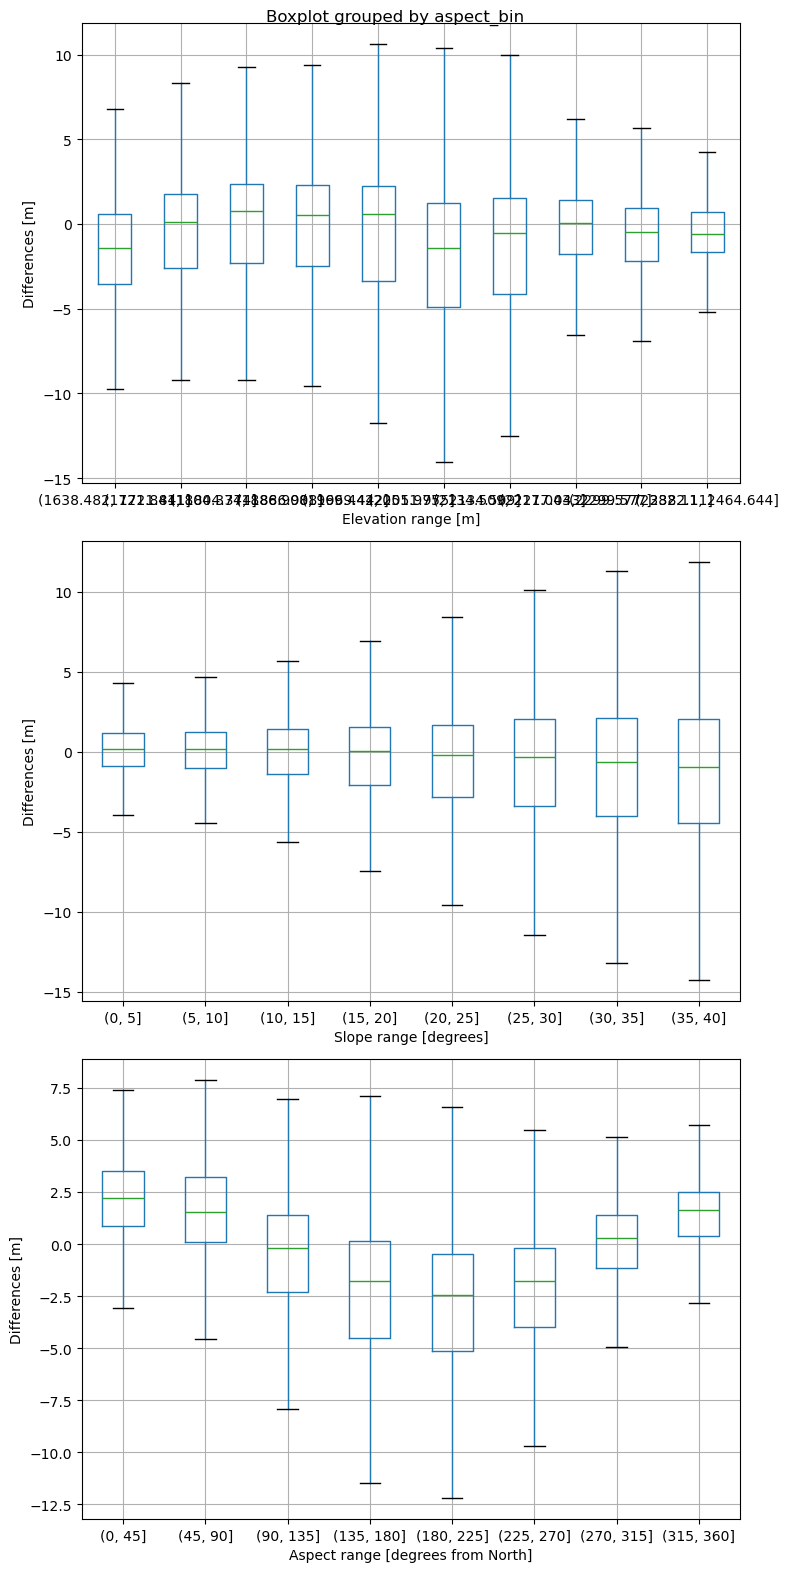

In [14]:
diff_after = coregister_difference(ref_dem_fn=refdem_fn, 
                                   source_dem_fn=sourcedem_fn, 
                                   ss_mask_fn=ss_fn, 
                                   coreg_method='GradientDescending', 
                                   coreg_ss_only=False)


### Gradient Descending - stable surfaces only

/opt/anaconda3/envs/snow-dems/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(


Calculating differences before coregistration...
Coregistering source DEM to reference DEM...
{'subsample': 6000, 'random_state': None, 'shift_x': 1.480375, 'shift_y': 1.5, 'shift_z': -19.6719970703125}
Calculating differences after coregistration...
Plotting results...


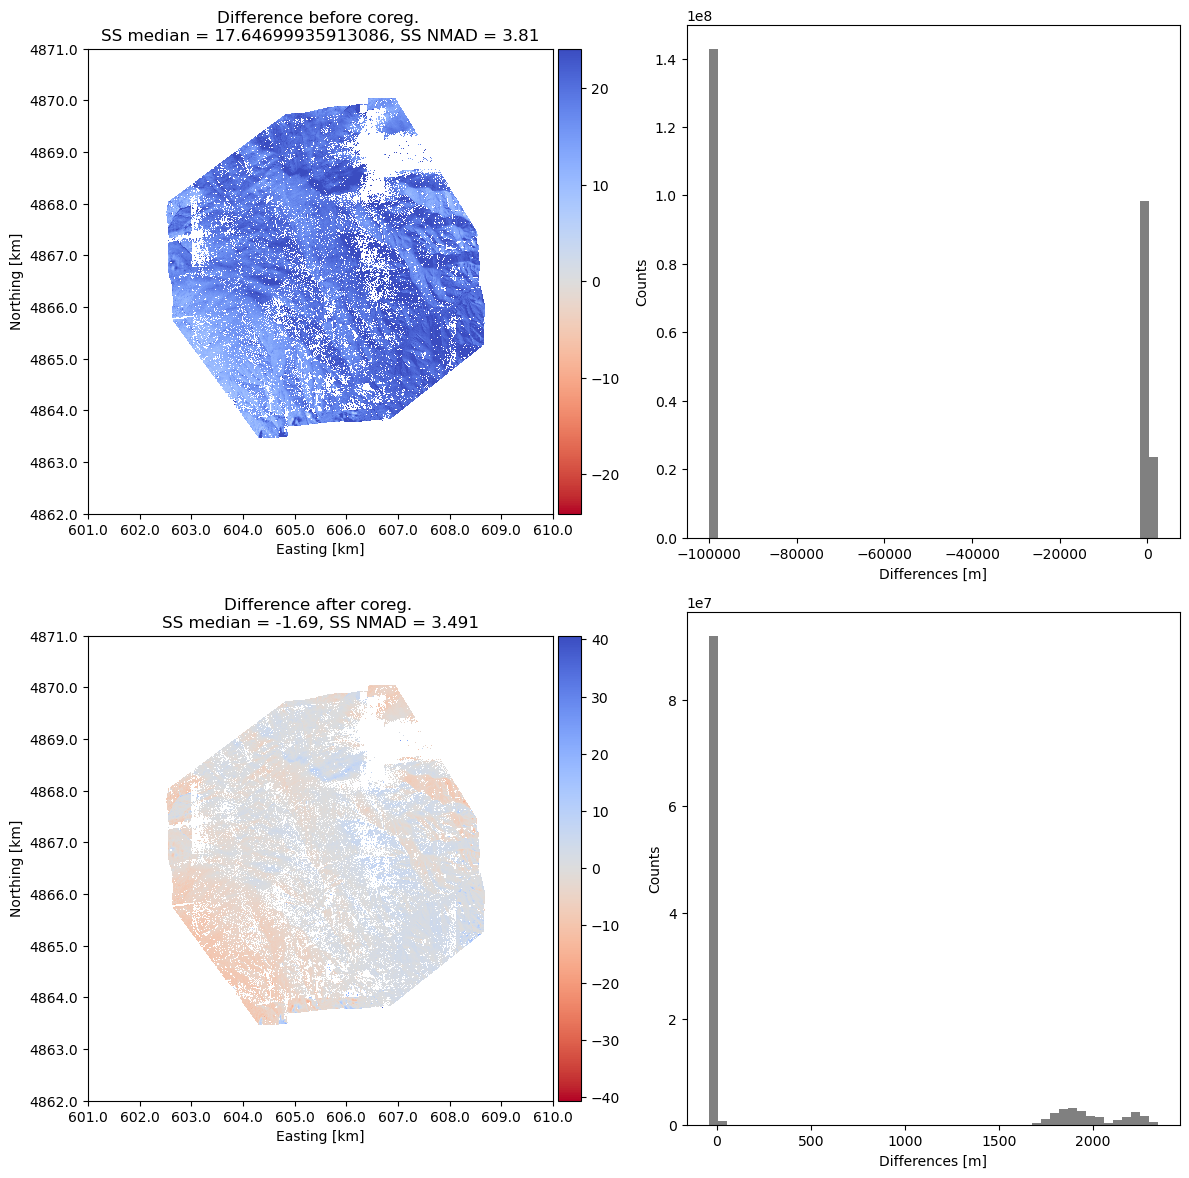

Calculating differences as a function of slope and aspect...


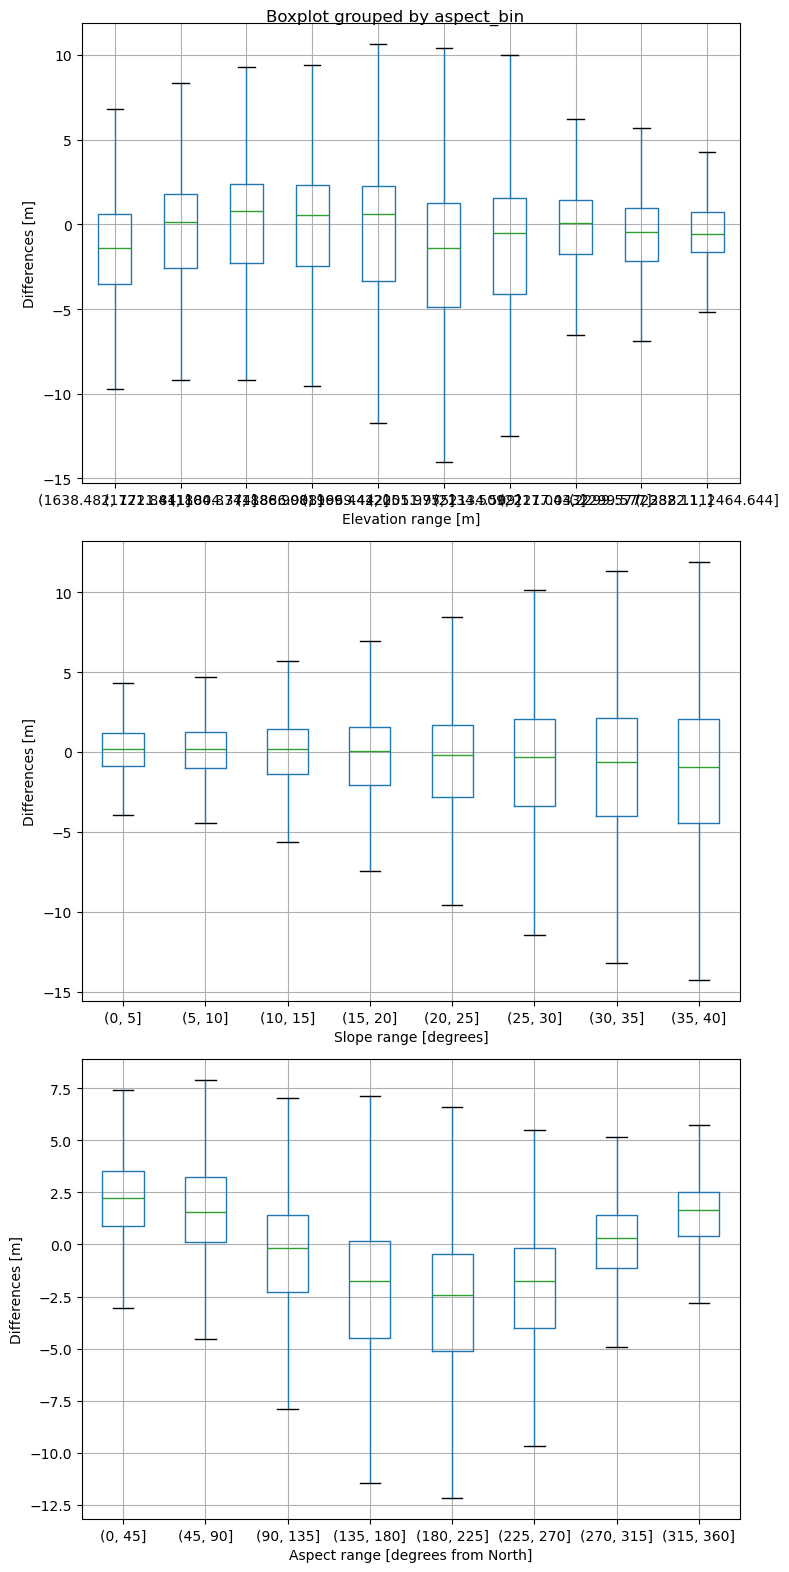

In [15]:
diff_after = coregister_difference(ref_dem_fn=refdem_fn, 
                                   source_dem_fn=sourcedem_fn, 
                                   ss_mask_fn=ss_fn, 
                                   coreg_method='GradientDescending', 
                                   coreg_ss_only=True)
